Посмотрим общую информацию о наборе данных. Описание столбцов:

 * eid - id группы событий (цепочки из показа и клика к нему, если был)

 * t - время

 * user - id пользователя
 
 * tn - тип события

 * geo -  id региона

 * cnethash - хеш от сети класса С, к которой принадлежит ip пользователя      

 * devtype - тип устройства

 * brotype - тип браузера

 * bsize - id размера банера (т.е. не сами размеры, а некий идентификатора размера)

 * siteid - id канала поставщика трафика

 * domhash - хеш от домена

 * urlhash - хеш от урла

In [40]:
import pandas as pd
import seaborn as sns
import numpy as np

sns.set(rc={'figure.figsize':(11.7,8.27)})

df = pd.read_table('../data/test_data.tsv')

df.head()

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
0,347854231724,1050848,21,0,3818162082,8335634595980108828,2,2,1642713892,1732823002,17261330804588317013,16521739535555380904
1,329455126064,694606,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
2,329455254926,694659,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
3,329455273798,694596,36,0,3818162082,2563013194488493467,3,2,3529439892,673473971,8781226038565509786,14273372146021722044
4,329455293738,694608,36,0,3818162082,2563013194488493467,3,2,390304810,673473971,8781226038565509786,14273372146021722044


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48672 entries, 0 to 48671
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   eid       48672 non-null  int64 
 1   t         48672 non-null  int64 
 2   user      48672 non-null  int64 
 3   tn        48672 non-null  int64 
 4   geo       48672 non-null  int64 
 5   cnethash  48672 non-null  uint64
 6   devtype   48672 non-null  int64 
 7   brotype   48672 non-null  int64 
 8   bsize     48672 non-null  int64 
 9   siteid    48672 non-null  int64 
 10  domhash   48672 non-null  uint64
 11  urlhash   48672 non-null  uint64
dtypes: int64(9), uint64(3)
memory usage: 4.5 MB


В наборе отсутствуют пустые значения, что не может не радовать. Все столбцы имеют численный формат. Предположу, что время дано в наносекундах. 

Вычислим сколько времени проходит между показами одному пользователю (столбец duration), а также поставим флаг 1, когда после показа рекламы, пользователь кликнул на нее (столбец flg).

In [42]:
df_sort = df.sort_values(by=['user', 't'], ascending=True, axis=0)
df_sort['duration'] = df_sort.groupby(by=['user'], as_index=False)['t'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).values
df_sort['flg'] = df_sort.groupby(by=['user'], as_index=False)['tn'].rolling(window=2).apply(lambda x: 1 if x.iloc[1] == 1 and x.iloc[0] == 0 else 0).values
df_sort.fillna(value=0, inplace=True)
df_sort[['user', 't', 'duration', 'tn', 'flg']].head(20)

,user,t,duration,tn,flg
0,21,1050848,0.0,0,0.0
3,36,694596,0.0,0,0.0
1,36,694606,10.0,0,0.0
4,36,694608,2.0,0,0.0
2,36,694659,51.0,0,0.0
5,121,256452,0.0,0,0.0
6,137,585721,0.0,0,0.0
7,148,463717,0.0,0,0.0
8,148,515262,51545.0,0,0.0
9,162,16301,0.0,0,0.0


In [43]:
df_sort.brotype.value_counts()

2     44830
9      2287
3       881
1       474
11      129
5        34
4        30
7         4
10        3
Name: brotype, dtype: int64

Большая часть запросов пришли с 2 типа браузера

In [44]:
df_user_click = df_sort[df_sort['flg'] == 1]
mean_val = df_user_click['duration'].mean()
median_val = df_user_click['duration'].median()

print(f'Среднее время, требующееся на клик: {mean_val}\nМедианное время, требующееся на клик: {median_val}')

n_init = df_user_click.shape[0]

Среднее время, требующееся на клик: 789.2948128693369
Медианное время, требующееся на клик: 7.0


Медианное и среднее значения очень сильно отличаются друг от друга. Данные сильно зашумлены. Посмотрим на распределение времени, потребующееся на клик

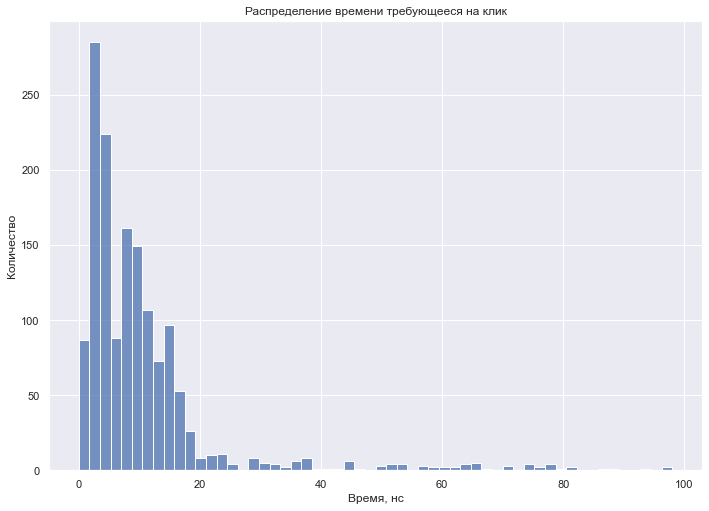

In [45]:
figure = sns.histplot(data=df_user_click[df_user_click['duration'] < 100], x='duration')
plot_conf = figure.set(xlabel ='Время, нс', ylabel = 'Количество', title ='Распределение времени требующееся на клик')

В целом, если верно мое предположение, что время дано в наносекундах, то возможно уже можно сделать вывод, что количество кликов накручено. Большая часть кликов происходит менее чем за 20 нс. Но тем не менее продолжу дальше исследовать данные.

Распределение очень похоже на экспоненциальное. Для удаления шумов я логарифмирую значения (чтобы значения сместились к центру), затем, используя интерквартильный размах, определю шумы. 
![delete_noise](./img/noise.png)

Удалено шумов 80


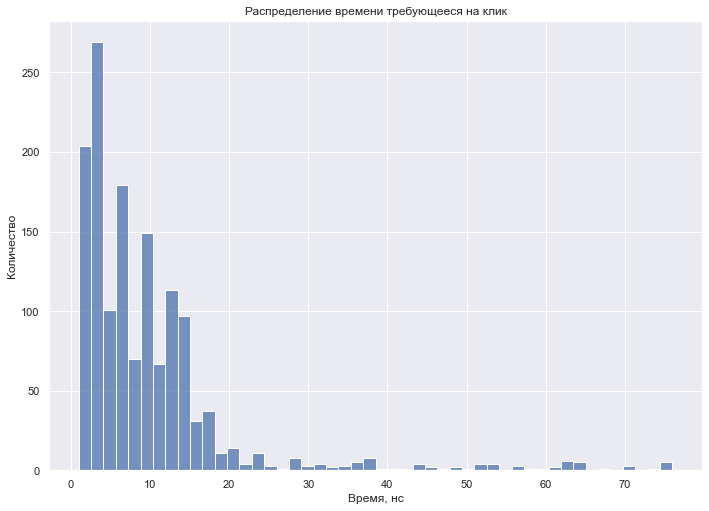

In [47]:
def tukey_noise(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]
    return df

df_user_click['log_duration'] = np.log(df_user_click['duration'].values)
df_user_click = tukey_noise(df_user_click, 'log_duration')
n_temp = df_user_click.shape[0]
print(f'Удалено шумов {n_init - n_temp}')

figure = sns.histplot(data=df_user_click, x='duration')
plot_conf = figure.set(xlabel ='Время, нс', ylabel = 'Количество', title ='Распределение времени требующееся на клик')

Предположу, что ботом является тот пользователь, у которого время, потребовавшееся на клик менее 1 нс. Посмотрим, на этих пользователей

In [67]:
users_bot = df_user_click[df_user_click['duration'] <= 5]
users_bot.head()

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,duration,flg,log_duration
42,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,4.0,1.0,1.386294
249,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572,2.0,1.0,0.693147
306,356485962288,1219612,1435,1,390304810,1192490853539771097,3,2,3529439892,2019279739,8416208933617365004,9497642917282163363,4.0,1.0,1.386294
315,13938138174,336280,1492,1,239476928,17272734299351518174,2,2,3529439892,1732823002,16593058030122958800,10314716605508635827,3.0,1.0,1.098612
413,324207227622,593770,1636,1,239476928,3395782206471752809,2,2,3529439892,1732823002,9977573133718727312,12302077756968376048,5.0,1.0,1.609438


In [76]:
df_user_click

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,duration,flg,log_duration
15,299522852624,72336,207,1,1539789858,1914105787300337336,2,2,3529439892,1732823002,6914246990831417846,7225540168013982636,63.0,1.0,4.143135
29,48923341882,1135684,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,15.0,1.0,2.708050
31,48925603446,1135717,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,9.0,1.0,2.197225
42,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,4.0,1.0,1.386294
93,16010841443,376051,920,1,390304810,2339536559139938629,2,2,2286540757,673473971,15630579387847758071,15271819797260967753,14.0,1.0,2.639057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48553,15879594241,373660,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,12589694513104196708,4064347458369280212,11.0,1.0,2.397895
48559,16203440514,379349,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,14587862015958063696,3666124054315925662,6.0,1.0,1.791759
48567,11601204597,276134,99334,1,3255688796,3386656292732252881,2,2,3529439892,3312146801,1461826196852647864,17388631505828371636,6.0,1.0,1.791759
48637,1987722430,40576,99649,1,2169085419,16112456752452597717,2,2,4059410016,1732823002,17566469994103955311,16564149921968231291,20.0,1.0,2.995732


In [77]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn import metrics
from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer
# from sklearn.mixture import GaussianMixture

df_cluster = df_user_click[['devtype', 'brotype', 'log_duration', 'flg', 'domhash', 'siteid']]

scaler = StandardScaler()
minmax = MinMaxScaler()

data_scaled = scaler.fit_transform(df_cluster)
data_scaled = pd.DataFrame(data=data_scaled, columns=df_cluster.columns, index=df_cluster.index)

data_scaled = minmax.fit_transform(data_scaled)
data_scaled = pd.DataFrame(data=data_scaled, columns=df_cluster.columns, index=df_cluster.index)

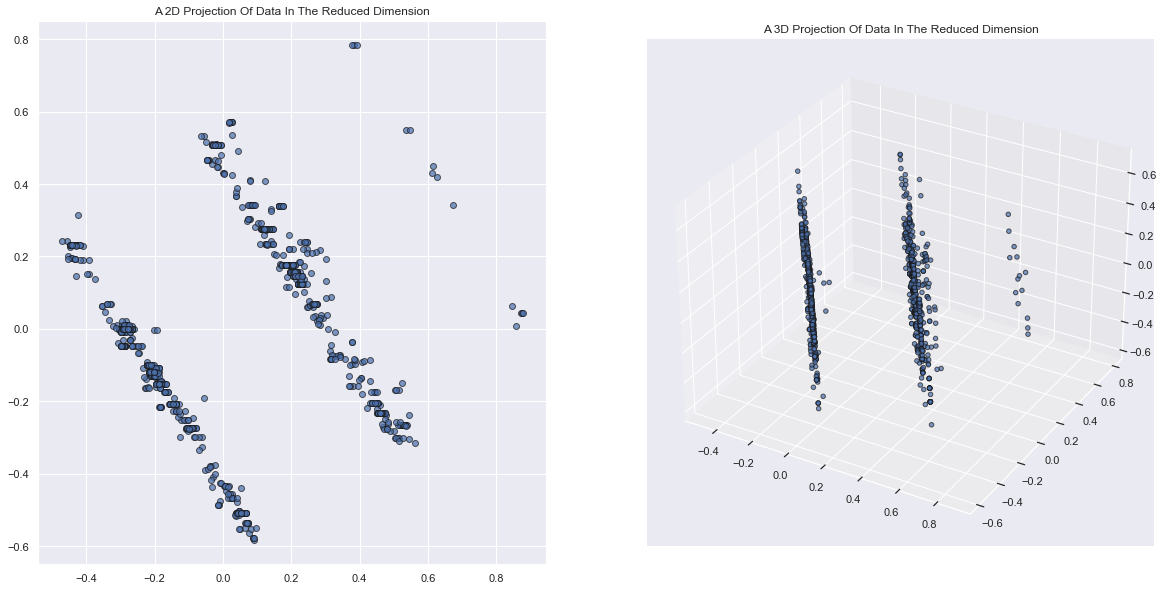

In [78]:
pca = decomposition.PCA(n_components=3)
X_pca_ratio_3d = pd.DataFrame(pca.fit_transform(data_scaled), columns=(["col1", "col2", "col3"]))

x =X_pca_ratio_3d["col1"]
y =X_pca_ratio_3d["col2"]
z =X_pca_ratio_3d["col3"]

#To plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(x,y,z, marker="o", cmap='rainbow', alpha=0.7, edgecolors='k')
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")

pca = decomposition.PCA(n_components=2)
X_pca_ratio_2d = pd.DataFrame(pca.fit_transform(data_scaled), columns=(["col1", "col2"]))

x = X_pca_ratio_2d["col1"]
y = X_pca_ratio_2d["col2"]

ax = fig.add_subplot(1, 2, 1)
ax.scatter(x,y, cmap='rainbow', alpha=0.7, edgecolors='k')
ax.set_title("A 2D Projection Of Data In The Reduced Dimension")
plt.show()

In [80]:
X_pca_ratio_2d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    1443 non-null   float64
 1   col2    1443 non-null   float64
dtypes: float64(2)
memory usage: 22.7 KB


In [79]:
km = KMeans(init='k-means++', n_clusters=3, random_state=42)
km_clustering = km.fit(X_pca_ratio_2d)

x =X_pca_ratio_2d["col1"]
y =X_pca_ratio_2d["col2"]
#To plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 2)
ax.scatter(x,y,c=km_clustering.labels_, marker="o", cmap='rainbow', alpha=0.7, edgecolors='k')
ax.set_title("KMeans")

gm = GaussianMixture(n_components=2, covariance_type='full', n_init=10, random_state=42)
labels = gm.fit_predict(X_pca_ratio_2d)

x =X_pca_ratio_2d["col1"]
y =X_pca_ratio_2d["col2"]
#To plot
ax = fig.add_subplot(1, 2, 1)
ax.scatter(x,y,c=labels, marker="o", cmap='rainbow', alpha=0.7, edgecolors='k')
ax.set_title("GaussianMixture")

plt.show()

D:\Program\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [79]:
user = df_sort[df_sort['flg'] == 1]
user[user['diff'] == 0]

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,diff,flg
1272,48405262873,1126959,3443,1,2348398181,3152613439364975948,3,2,390304810,2019279739,7589661441840127586,13552381492480484636,0.0,1.0
2790,29286788630,698578,4054,1,948975964,1849054166541245772,3,2,3529439892,673473971,11431726898412966699,8923013773647664430,0.0,1.0
5513,296644449388,2959,9471,1,1683184212,4844995861121288436,3,2,4059410016,2019279739,8537674138698941665,2258268291254262431,0.0,1.0
7858,326574083092,631245,14887,1,3369870328,8152637166701363697,2,2,2286540757,673473971,4914594979331280657,11559962283453168694,0.0,1.0
11059,312418750060,339327,18870,1,3925218118,9065144654854432934,3,2,390304810,2019279739,10748006104492753672,2136731957930523582,0.0,1.0
14577,19263626167,460176,25658,1,3255688796,738941662003109476,2,2,2286540757,673473971,12816944840592924020,18231032288951453953,0.0,1.0
15293,315679173619,401593,26367,1,3805942148,13136189517371146609,2,2,4059410016,673473971,15630579387847758071,2882898147537860039,0.0,1.0
16779,24010004482,578713,29537,1,2169085419,17332689675803212787,3,2,4059410016,1732823002,5398870908427309388,7145879351273368377,0.0,1.0
23659,35870563202,843661,40023,1,1642713892,7589958751968777860,2,2,1642713892,673473971,9637082841571769563,12823190742759060193,0.0,1.0
25137,355182250793,1199396,45811,1,1778249539,6174911276659299031,3,2,1642713892,673473971,718179210786408666,13014410942702966098,0.0,1.0


In [81]:
df_sort[df_sort['user'] == 3443][['user', 't', 'diff', 'tn', 'flg']]

,user,t,diff,tn,flg
1343,3443,873000,0.0,0,NaN
1344,3443,873019,19.0,0,0.0
1345,3443,873038,19.0,0,0.0
1346,3443,873039,1.0,1,1.0
1347,3443,874631,1592.0,0,0.0
...,...,...,...,...,...
1502,3443,1219674,1.0,0,0.0
1503,3443,1219674,0.0,0,0.0
1504,3443,1219689,15.0,0,0.0
1505,3443,1219690,1.0,0,0.0


In [36]:
window_size = 15
df_sort_by_time = df.sort_values(by=['t'], ascending=True, axis=0)
df_sort_by_time['count_user'] = df_sort_by_time.groupby(by=['t'])['user'].transform('size')
df_sort_by_time['sum_user'] = df_sort_by_time.groupby(by=['t'])['count_user'].sum()
df_sort_by_time[['user', 't', 'count_user', 'tn']].head(30)

,user,t,count_user,tn
22590,38926,0,4,0
24847,44890,0,4,0
29271,55622,0,4,0
44986,93204,0,4,0
29738,56971,1,1,0
5192,8427,3,1,0
24498,44363,6,1,0
44985,93204,11,1,0
7025,13191,945,1,0
19198,34170,1394,1,0


In [81]:
df_count_user = df_sort_by_time.groupby(by=['t'], as_index=False)['user'].count()
df_count_user['sum'] = df_count_user['user'].cumsum()
df_count_user['date'] = pd.to_datetime(df_count_user['t'])
# df_count_user.set_index('date', inplace=True)
df_count_user.tail()

,t,user,sum,date
37270,1248885,1,48664,1970-01-01 00:00:00.001248885
37271,1248901,1,48665,1970-01-01 00:00:00.001248901
37272,1248916,1,48666,1970-01-01 00:00:00.001248916
37273,1248944,3,48669,1970-01-01 00:00:00.001248944
37274,1248945,3,48672,1970-01-01 00:00:00.001248945


<AxesSubplot:xlabel='date'>

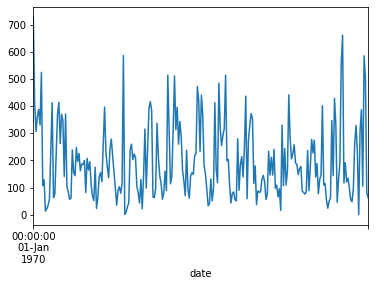

In [86]:
period_ns = 5000
df_grouped = df_count_user.groupby(pd.Grouper(key='date', freq=f'{period_ns}ns'))
df_avg = df_grouped['user'].sum()
df_avg.plot()

In [79]:
df_avg

date
1970-01-01 00:00:00.000000      9
1970-01-01 00:00:00.000001    129
1970-01-01 00:00:00.000002    394
1970-01-01 00:00:00.000003    140
1970-01-01 00:00:00.000004     57
                             ... 
1970-01-01 00:00:00.001244     10
1970-01-01 00:00:00.001245     12
1970-01-01 00:00:00.001246      9
1970-01-01 00:00:00.001247      8
1970-01-01 00:00:00.001248     33
Freq: 1000N, Name: user, Length: 1249, dtype: int64

In [63]:
(df_count_user['date'][1] - df_count_user['date'][0]).dt.ns

AttributeError: 'Timedelta' object has no attribute 'dt'

In [54]:
df1s = df_count_user.asfreq('15NS')
df1s

,user,sum
t,,
1970-01-01 00:00:00.000000000,NaN,NaN
1970-01-01 00:00:00.000000015,NaN,NaN
1970-01-01 00:00:00.000000030,NaN,NaN
1970-01-01 00:00:00.000000045,NaN,NaN
1970-01-01 00:00:00.000000060,NaN,NaN
...,...,...
1970-01-01 00:00:00.001248885,NaN,NaN
1970-01-01 00:00:00.001248900,NaN,NaN
1970-01-01 00:00:00.001248915,NaN,NaN


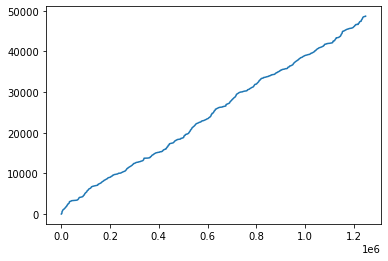

In [43]:
plt.plot(df_count_user['t'], df_count_user['sum'])

ValueError: `bins` must increase monotonically, when an array

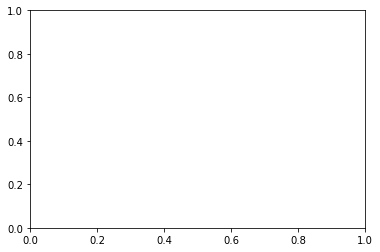

In [45]:
plt.plot(df_count_user['t'], df_count_user['user'])

In [24]:
max(df_sort_by_time['count_user'])

9

In [34]:
df_click = df_sort[df_sort['tn'] == 1]
df_click[['user', 't', 'tn', 'count_tn']].tail(20)

,user,t,tn,count_tn
48316,98471,856944,1,1
48323,98471,1072127,1,1
48346,98471,1177126,1,1
48352,98530,45781,1,1
48357,98563,700850,1,1
48360,98563,790449,1,1
48415,98931,979536,1,1
48417,98931,979621,1,1
48419,98931,979710,1,1
48421,98931,979802,1,1


<AxesSubplot:>

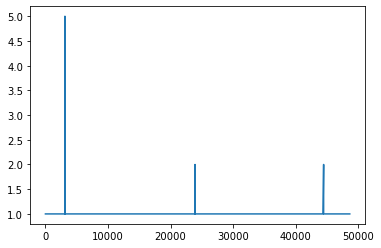

In [35]:
df_click['count_tn'].plot()

In [46]:
df_sort = df.sort_values(by=['t', 'user'], ascending=True, axis=0)
df_sort.head(20)

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
22590,296498041966,0,38926,0,2960729952,4497107830165114780,3,2,4059410016,2854608146,12730410806028401995,16483834158416016169
24847,296498024394,0,44890,0,3954886488,14216238522239466372,3,2,390304810,1732823002,1722448919440554866,10377541731081980808
29271,296498039502,0,55622,0,3954886488,7015657601765301350,3,2,4059410016,2854608146,12730410806028401995,16483834158416016169
44986,296498021138,0,93204,0,3369870328,6597077236420332770,3,2,3529439892,1732823002,8869952127782578504,457855908399451175
29738,81151,1,56971,0,1621335485,3296446705165215755,2,2,3529439892,251638358,4891187163287196005,6410865403419361398
5192,0,3,8427,0,2169085419,4381405136034962231,3,2,3529439892,1732823002,9165165400812287640,9134515497888859819
24498,6017,6,44363,0,3954886488,4662180041601007799,2,2,2286540757,1732823002,10789946446251214146,16192386849549677883
44985,296498021108,11,93204,0,3369870328,6597077236420332770,3,2,3529439892,1732823002,8869952127782578504,457855908399451175
7025,296546374440,945,13191,0,3805942148,16754459184407223127,3,2,390304810,2019279739,1454947556417141887,10591841311320316925
19198,57597824,1394,34170,0,239476928,15462246925104753572,2,2,390304810,2019279739,11825093272774311640,363308052257304157


In [48]:
df_sort['traffic'] = df_sort.groupby(by=['t'])['user'].transform('size')
df_sort[['t', 'user', 'tn', 'traffic']].head(20)

,t,user,tn,traffic
22590,0,38926,0,4
24847,0,44890,0,4
29271,0,55622,0,4
44986,0,93204,0,4
29738,1,56971,0,1
5192,3,8427,0,1
24498,6,44363,0,1
44985,11,93204,0,1
7025,945,13191,0,1
19198,1394,34170,0,1


In [50]:
max(df_sort['traffic'])

9

<AxesSubplot:>

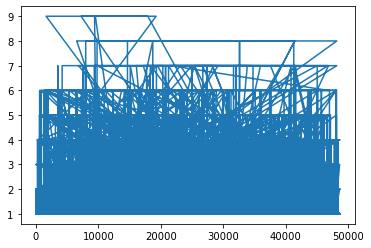

In [51]:
df_sort['traffic'].plot()

In [21]:
df.head()

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,date
0,347854231724,1050848,21,0,3818162082,8335634595980108828,2,2,1642713892,1732823002,17261330804588317013,16521739535555380904,1970-01-01
1,329455126064,694606,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044,1970-01-01
2,329455254926,694659,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044,1970-01-01
3,329455273798,694596,36,0,3818162082,2563013194488493467,3,2,3529439892,673473971,8781226038565509786,14273372146021722044,1970-01-01
4,329455293738,694608,36,0,3818162082,2563013194488493467,3,2,390304810,673473971,8781226038565509786,14273372146021722044,1970-01-01


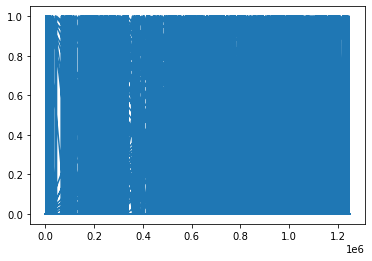

In [27]:
import matplotlib.pyplot as plt

plt.plot(df['t'], df['tn'])

In [52]:
df_group = df.groupby(by=['t', 'user', 'tn'])['tn'].count()
df_group.head()

t  user   tn
0  38926  0     1
   44890  0     1
   55622  0     1
   93204  0     1
1  56971  0     1
Name: tn, dtype: int64

In [54]:
df_group.index

MultiIndex([(      0, 38926, 0),
            (      0, 44890, 0),
            (      0, 55622, 0),
            (      0, 93204, 0),
            (      1, 56971, 0),
            (      3,  8427, 0),
            (      6, 44363, 0),
            (     11, 93204, 0),
            (    945, 13191, 0),
            (   1394, 34170, 0),
            ...
            (1248859, 65336, 0),
            (1248860, 65336, 0),
            (1248874, 65336, 0),
            (1248875, 65336, 0),
            (1248876, 65336, 0),
            (1248885, 65336, 0),
            (1248901, 65336, 0),
            (1248916, 65336, 0),
            (1248944, 65336, 0),
            (1248945, 65336, 0)],
           names=['t', 'user', 'tn'], length=38169)

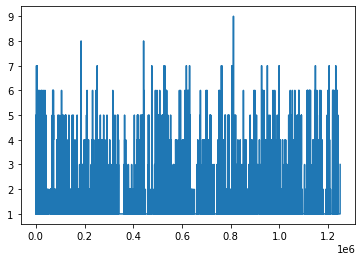

In [74]:
import matplotlib.pyplot as plt

plt.plot(test.get_level_values(0), df_group, )

In [72]:
test = df_group.index

In [73]:
test.get_level_values(0)

Int64Index([      0,       0,       0,       0,       1,       3,       6,
                 11,     945,    1394,
            ...
            1248859, 1248860, 1248874, 1248875, 1248876, 1248885, 1248901,
            1248916, 1248944, 1248945],
           dtype='int64', name='t', length=38169)

In [70]:
df_group.index.get_indexer('tn')

TypeError: Index(...) must be called with a collection of some kind, 'tn' was passed